In [1]:
from params import *
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
ts_full.index

DatetimeIndex(['1955-11-01', '1955-11-02', '1955-11-03', '1955-11-04',
               '1955-11-05', '1955-11-06', '1955-11-07', '1955-11-08',
               '1955-11-09', '1955-11-10',
               ...
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11'],
              dtype='datetime64[ns]', name='Date', length=22169, freq=None)

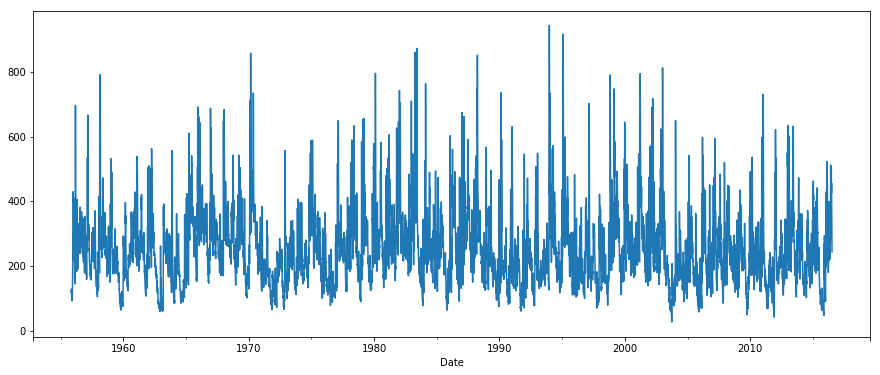

In [2]:
ts_full.plot()

/usr/lib64/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


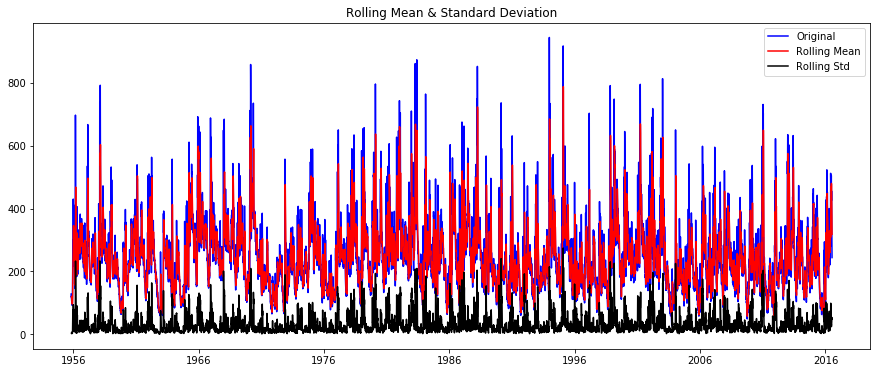

Results of Dickey-Fuller Test:
Test Statistic                -1.402579e+01
p-value                        3.505363e-26
#Lags Used                     3.200000e+01
Number of Observations Used    2.213600e+04
Critical Value (10%)          -2.566840e+00
Critical Value (1%)           -3.430645e+00
Critical Value (5%)           -2.861671e+00
dtype: float64


In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts_full)

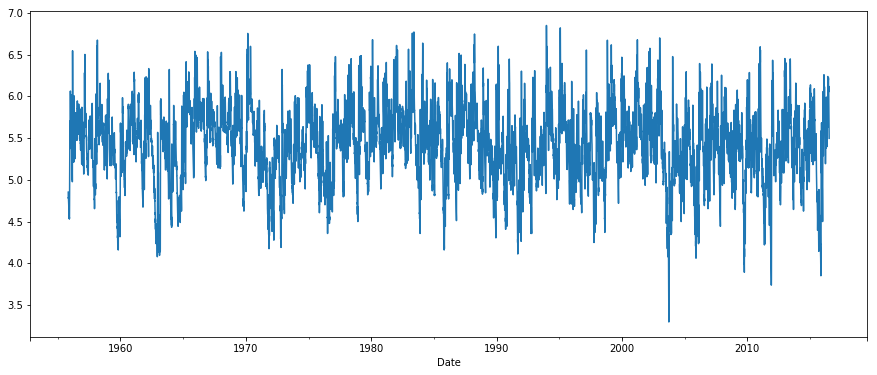

In [4]:
ts_full_log = np.log(ts_full)
ts_full_log.plot()

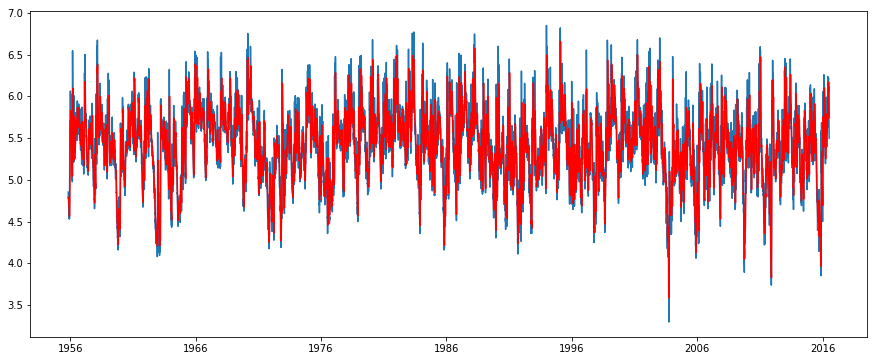

In [5]:
moving_avg = pd.Series.rolling(ts_full_log,12).mean()
plt.plot(ts_full_log)
plt.plot(moving_avg, color='red')

In [6]:
ts_full_log_moving_avg_diff = ts_full_log - moving_avg
ts_full_log_moving_avg_diff.head(12)

Date
1955-11-01         NaN
1955-11-02         NaN
1955-11-03         NaN
1955-11-04         NaN
1955-11-05         NaN
1955-11-06         NaN
1955-11-07         NaN
1955-11-08         NaN
1955-11-09         NaN
1955-11-10         NaN
1955-11-11         NaN
1955-11-12   -0.025657
Name: W [cm], dtype: float64

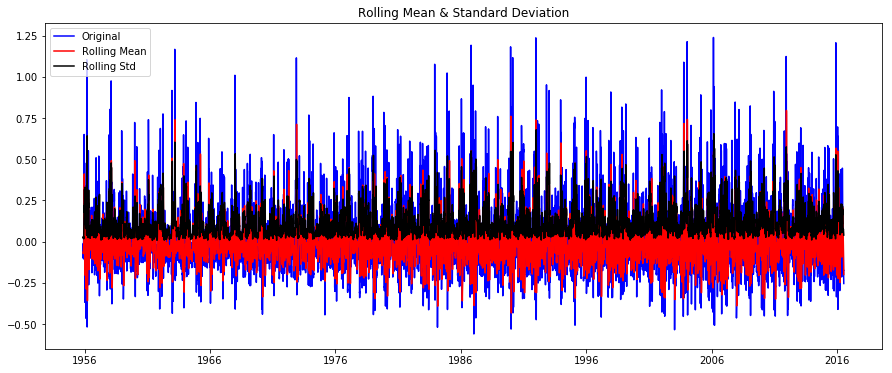

Results of Dickey-Fuller Test:
Test Statistic                   -26.807070
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    22112.000000
Critical Value (10%)              -2.566840
Critical Value (1%)               -3.430646
Critical Value (5%)               -2.861671
dtype: float64


In [7]:
ts_full_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_full_log_moving_avg_diff)

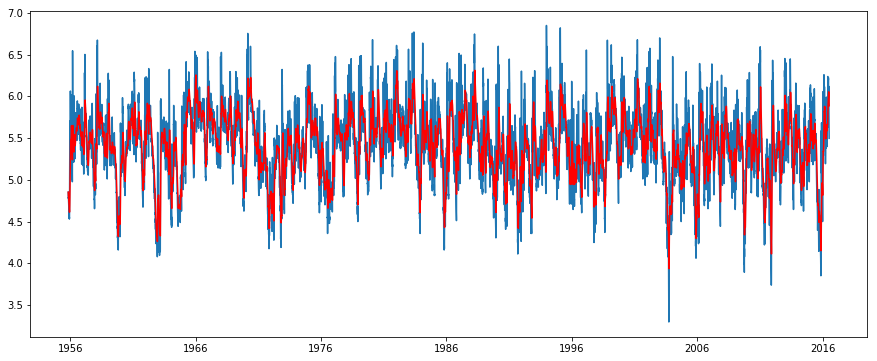

In [8]:
expwighted_avg = pd.Series.ewm(ts_full_log, halflife=12).mean()
plt.plot(ts_full_log)
plt.plot(expwighted_avg, color='red')

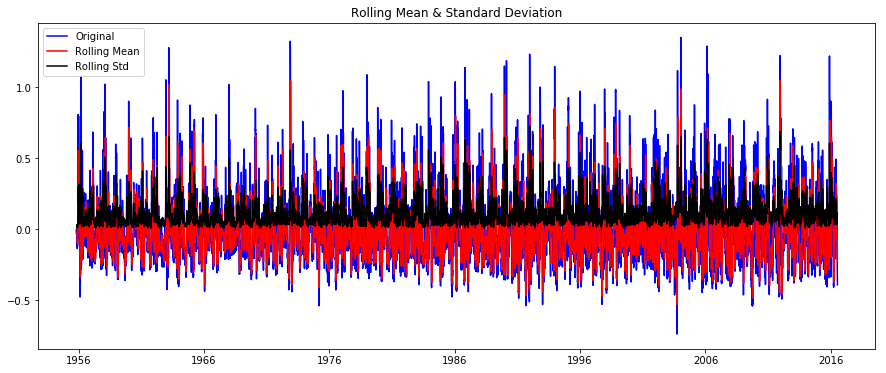

Results of Dickey-Fuller Test:
Test Statistic                   -24.183226
p-value                            0.000000
#Lags Used                        34.000000
Number of Observations Used    22134.000000
Critical Value (10%)              -2.566840
Critical Value (1%)               -3.430645
Critical Value (5%)               -2.861671
dtype: float64


22169

In [9]:
ts_full_log_ewma_diff = ts_full_log - expwighted_avg
test_stationarity(ts_full_log_ewma_diff)
len(ts_full)

## Eliminating Trend and Seasonality

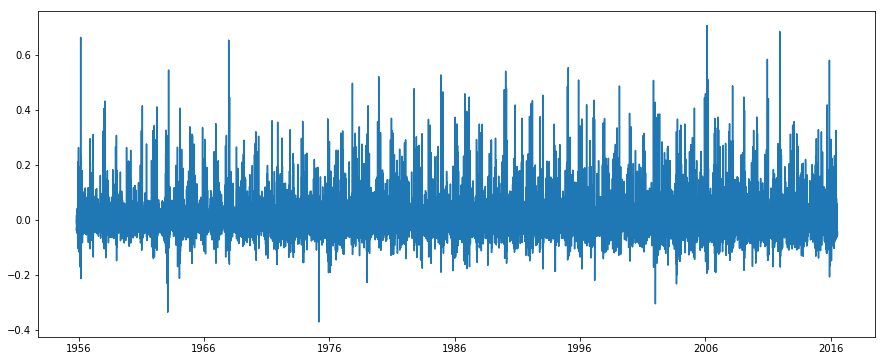

In [10]:
# Differencing
ts_full_log_diff = ts_full_log - ts_full_log.shift()
plt.plot(ts_full_log_diff)

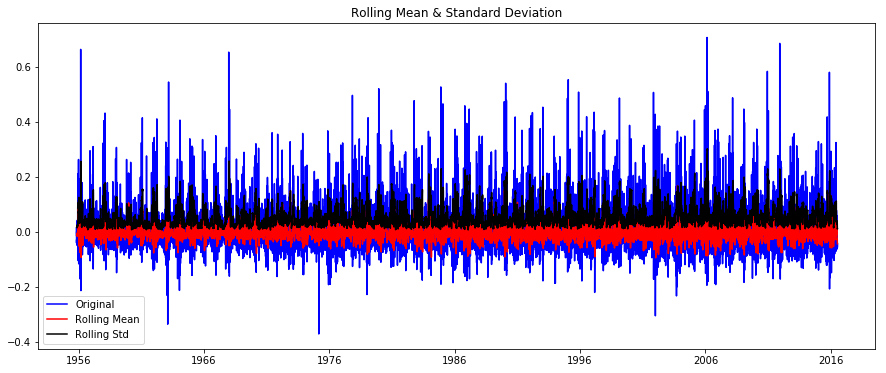

Results of Dickey-Fuller Test:
Test Statistic                   -30.740454
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    22127.000000
Critical Value (10%)              -2.566840
Critical Value (1%)               -3.430646
Critical Value (5%)               -2.861671
dtype: float64


In [11]:
ts_full_log_diff.dropna(inplace=True)
test_stationarity(ts_full_log_diff)

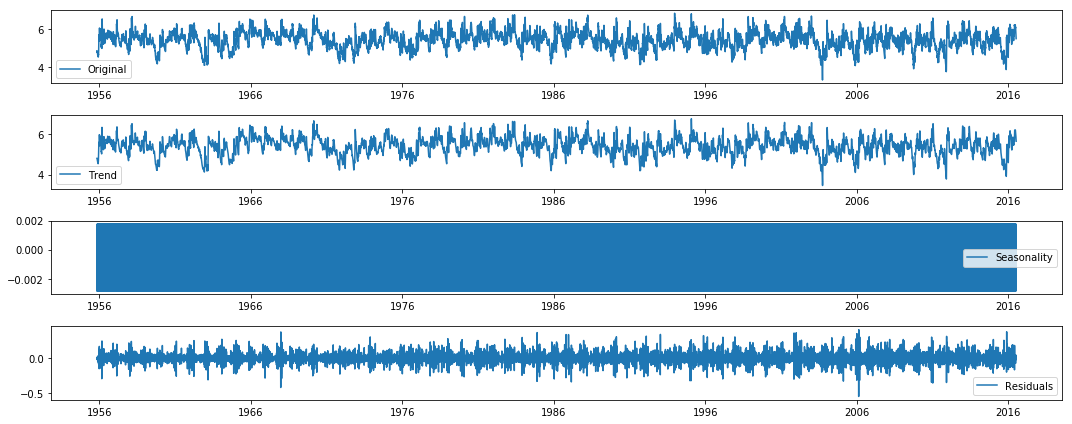

In [12]:
# Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_full_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_full_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

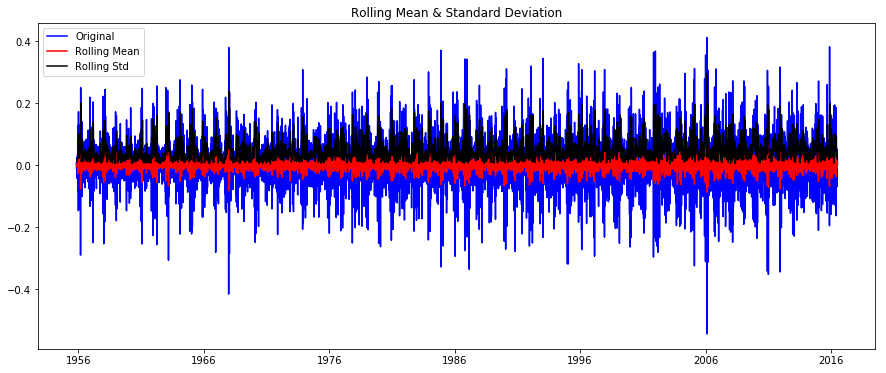

Results of Dickey-Fuller Test:
Test Statistic                   -39.690771
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    22115.000000
Critical Value (10%)              -2.566840
Critical Value (1%)               -3.430646
Critical Value (5%)               -2.861671
dtype: float64


In [13]:
ts_full_log_decompose = residual
ts_full_log_decompose.dropna(inplace=True)
test_stationarity(ts_full_log_decompose)

## Forecasting a Time Series

In [14]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_full_log_diff, nlags=20)
lag_pacf = pacf(ts_full_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

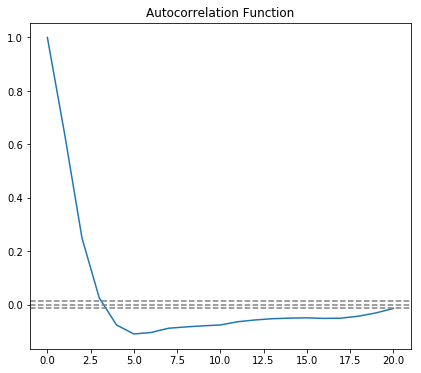

In [15]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_full_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_full_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

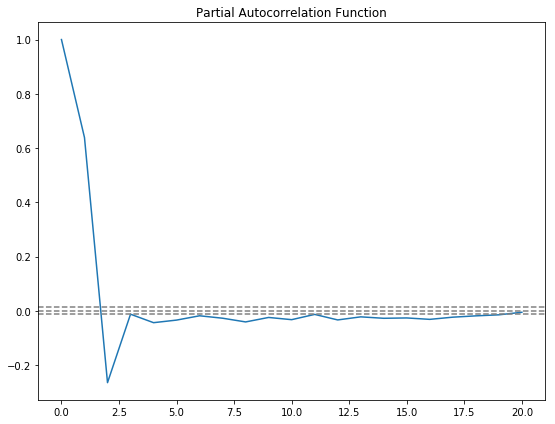

In [16]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_full_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_full_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## ARIMA model

In [17]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5,1,'RSS: 69.0146')

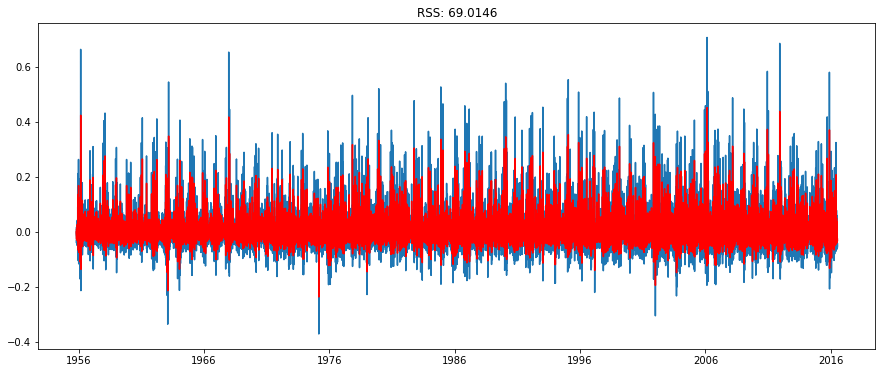

In [18]:
# AR-Model
model = ARIMA(ts_full_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_full_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_full_log_diff)**2))

Text(0.5,1,'RSS: 71.5985')

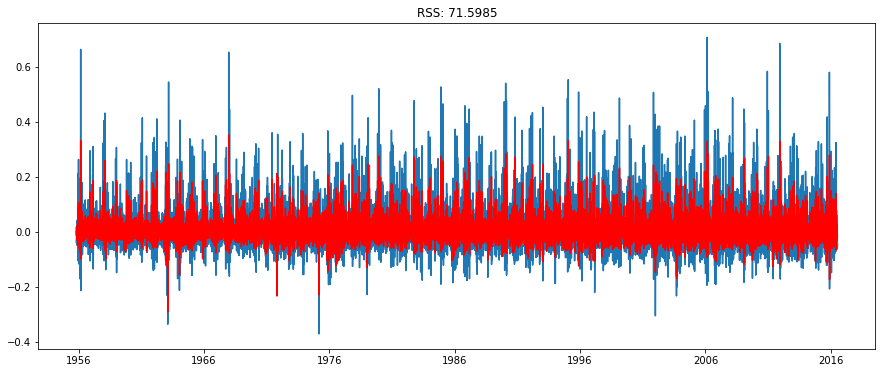

In [19]:
# MA model
model = ARIMA(ts_full_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_full_log_diff)
plt.plot(results_MA.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_full_log_diff)**2))

Text(0.5,1,'RSS: 64.7697')

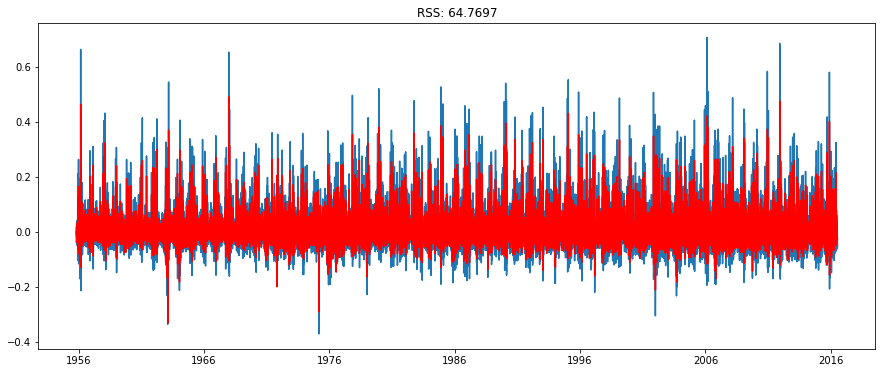

In [20]:
# ARIMA Model
model = ARIMA(ts_full_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_full_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_full_log_diff)**2))

In [25]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
1955-11-02    0.000025
1955-11-03   -0.020440
1955-11-04   -0.025395
1955-11-05    0.021957
1955-11-06   -0.000984
dtype: float64
Date
1955-11-02    0.000025
1955-11-03   -0.020415
1955-11-04   -0.045810
1955-11-05   -0.023853
1955-11-06   -0.024837
dtype: float64


In [26]:
predictions_ARIMA_log = pd.Series(ts_full_log.iloc[0], index=ts_full_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1955-11-01    4.852030
1955-11-02    4.852055
1955-11-03    4.831615
1955-11-04    4.806220
1955-11-05    4.828177
dtype: float64

Text(0.5,1,'RMSE: nan')

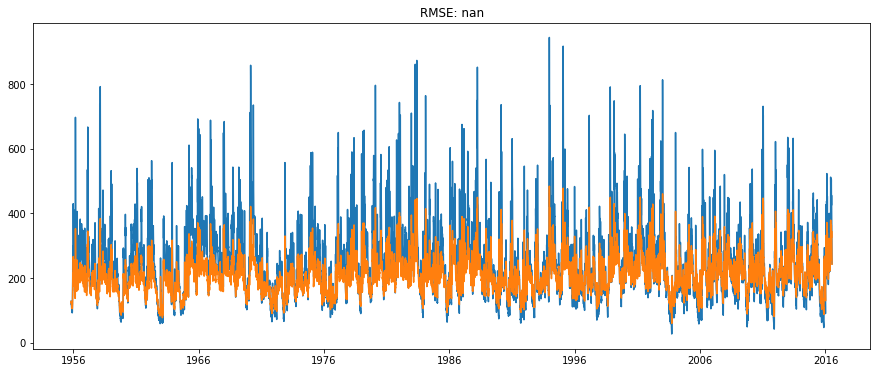

In [27]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_full)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts_full)))

### References:
https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
